In [1]:
import os
import json
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 


from utils.vis import plot_images_nib, plot_images, analyze_inhale_exhale, plot_slice
from utils.preprocessing import hu_data, remove_gantry, apply_clahe, convert_signed_4bit_to_hu, convert_to_signed_4bit, fill_chest_cavity
from utils.segment import apply_lungmask_binary

In [2]:
DATA_PATH = './data'
RESULT_PATH = './results'
PARAMETER_PATH = './parameter'
ELASTIX_PATH = '/Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/elastix'
dataset_info = json.load(open("./data/dataset_info.json"))
save = False
vis = False

# Image Check

In [3]:
key = 'copd4'
inhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz'))
exhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz'))
inhale_data = inhale_image.get_fdata()
exhale_data = exhale_image.get_fdata()

In [4]:
if vis == True:
    plot_images_nib([inhale_image, exhale_image], titles=[f"{key} Inhale", f"{key} Exhale"], cols=2, slice_idx=50, fig_size=(10, 10))

In [5]:
if vis == True:
    analyze_inhale_exhale(inhale_data, exhale_data)

In [6]:
hu_inhale = hu_data(inhale_data)
hu_exhale = hu_data(exhale_data)

In [7]:
if vis == True:
    analyze_inhale_exhale(hu_inhale, hu_exhale)

In [8]:
if save == True:
    inhale_save = os.path.join(DATA_PATH, key, f'{key}_iBHCT_hu.nii.gz')
    exhale_save = os.path.join(DATA_PATH, key, f'{key}_eBHCT_hu.nii.gz')

    inhale_image_hu = nib.Nifti1Image(hu_inhale, inhale_image.affine)
    exhale_image_hu = nib.Nifti1Image(hu_exhale, exhale_image.affine)
    nib.save(inhale_image_hu, inhale_save)
    nib.save(exhale_image_hu, exhale_save)

In [42]:
bit_4 = convert_to_signed_4bit(hu_exhale)
bit_4_hu = convert_signed_4bit_to_hu(bit_4)

In [11]:
def convert_signed_4bit_to_unsigned_8bit(ct_image_4bit):
    """
    Converts a signed 4-bit CT image (range: [-8, 7]) to an unsigned 8-bit image (range: [0, 255]).
    
    Parameters:
        ct_image_4bit (numpy.ndarray): The signed 4-bit CT image (range: [-8, 7]).
    
    Returns:
        numpy.ndarray: The unsigned 8-bit image (range: [0, 255]).
    """
    # Ensure the input range is valid
    if not np.all((ct_image_4bit >= -8) & (ct_image_4bit <= 7)):
        raise ValueError("Input image values must be in the range [-8, 7].")
    
    # Scale signed 4-bit range [-8, 7] to unsigned 8-bit range [0, 255]
    ct_image_8bit = ((ct_image_4bit + 8) / 15 * 255).astype(np.uint8)
    
    return ct_image_8bit

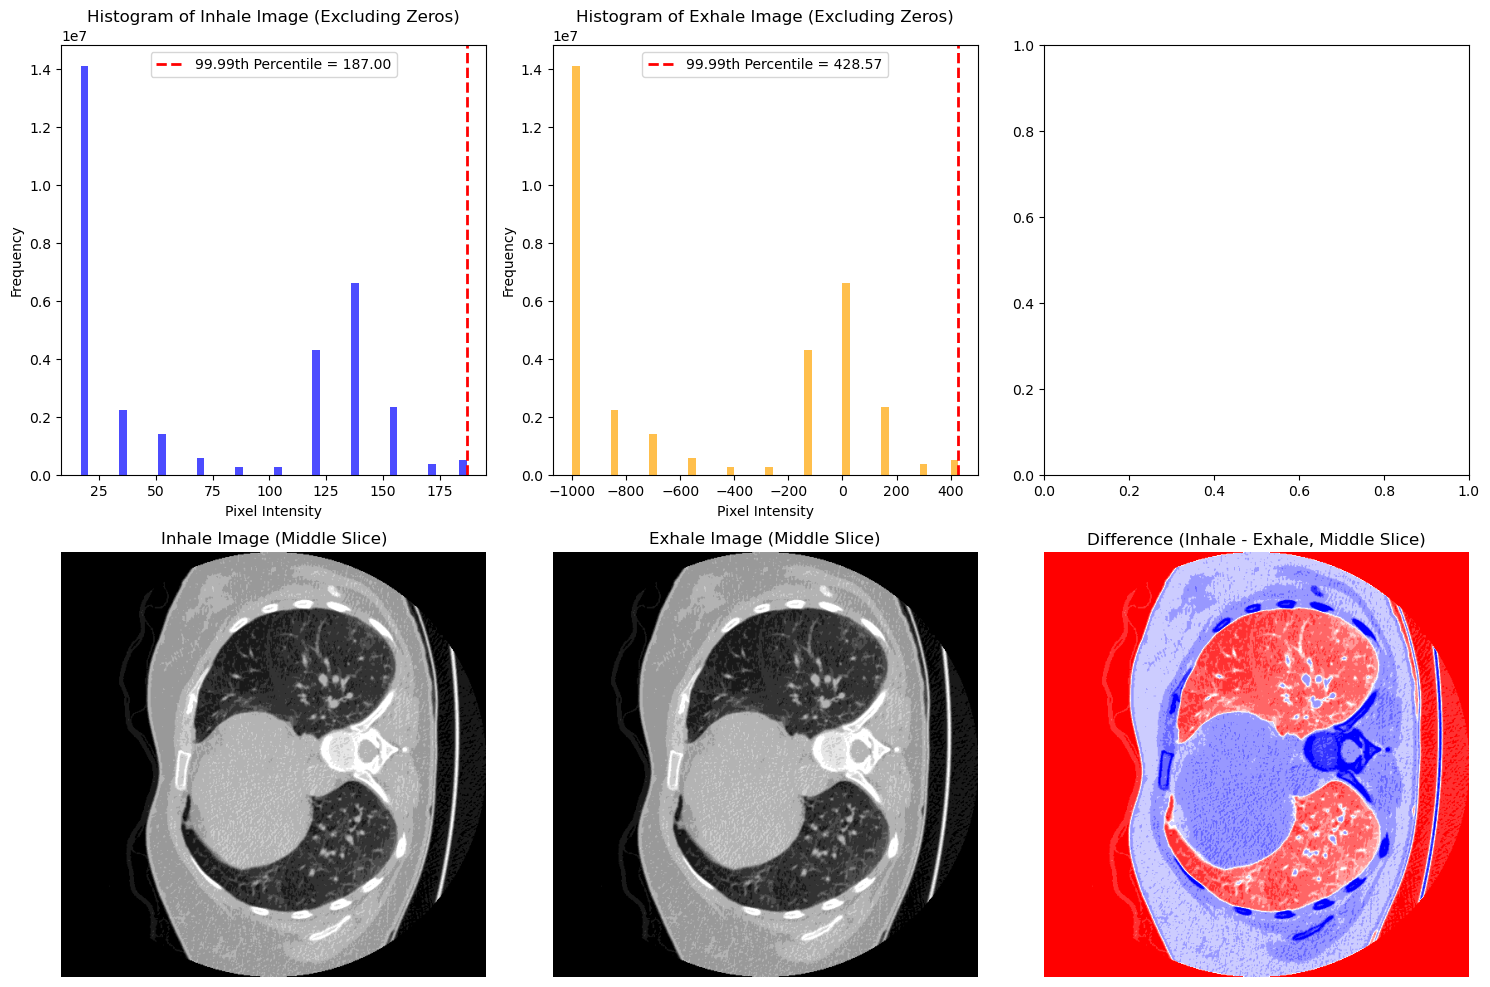

Dataset - Inhale Image Statistics:
Min: 17
Min (Excluding Zeros): 17
Max: 187
Image Type: uint8
Intensity Range: (17, 187)
Voxel Count (Total): 33030144
Voxel Count (Non-Zero): 33030144
99.99th Percentile: 187.0

Dataset - Exhale Image Statistics:
Min: -1000.0
Min (Excluding Zeros): 142.85714285714286
Max: 428.57142857142856
Image Type: float64
Intensity Range: (-1000.0, 428.57142857142856)
Voxel Count (Total): 33030144
Voxel Count (Non-Zero): 26400934
99.99th Percentile: 428.57142857142856


{'Inhale': {'Min': 17,
  'Min (Excluding Zeros)': 17,
  'Max': 187,
  'Image Type': 'uint8',
  'Intensity Range': (17, 187),
  'Voxel Count (Total)': 33030144,
  'Voxel Count (Non-Zero)': 33030144,
  '99.99th Percentile': 187.0},
 'Exhale': {'Min': -1000.0,
  'Min (Excluding Zeros)': 142.85714285714286,
  'Max': 428.57142857142856,
  'Image Type': 'float64',
  'Intensity Range': (-1000.0, 428.57142857142856),
  'Voxel Count (Total)': 33030144,
  'Voxel Count (Non-Zero)': 26400934,
  '99.99th Percentile': 428.57142857142856}}

In [46]:
analyze_inhale_exhale(convert_signed_4bit_to_unsigned_8bit(bit_4), bit_4_hu)

In [43]:
_, threshold = cv2.threshold(convert_signed_4bit_to_unsigned_8bit(bit_4), 80, 255, cv2.THRESH_BINARY)

In [44]:
threshold_ = np.bitwise_not(threshold)

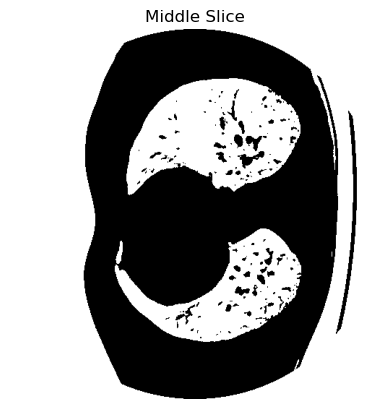

In [45]:
plot_slice(threshold_)

In [63]:
mask = extract_central_objects_3d(threshold_)

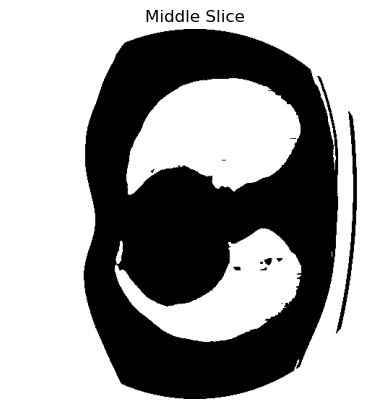

In [64]:
plot_slice(mask)

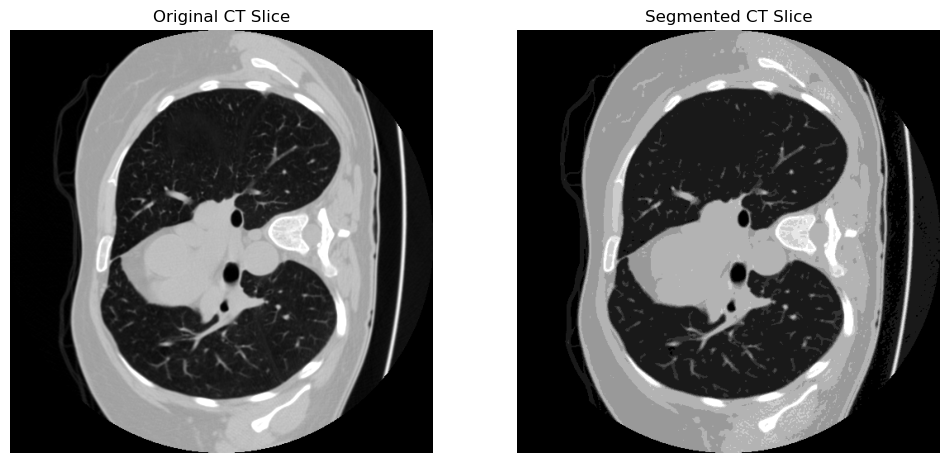

In [22]:

# Visualize a single slice of the segmented 3D image
slice_idx = 50  # Choose a slice index
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(hu_inhale[:, :, slice_idx], cmap="gray")
plt.title("Original CT Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bit_4[:, :, slice_idx], cmap="gray")
plt.title("Segmented CT Slice")
plt.axis("off")

plt.show()

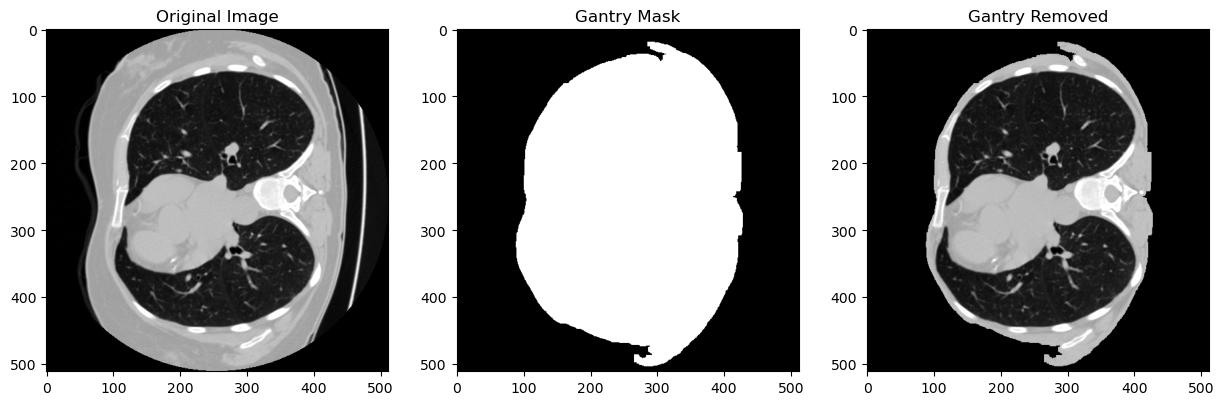

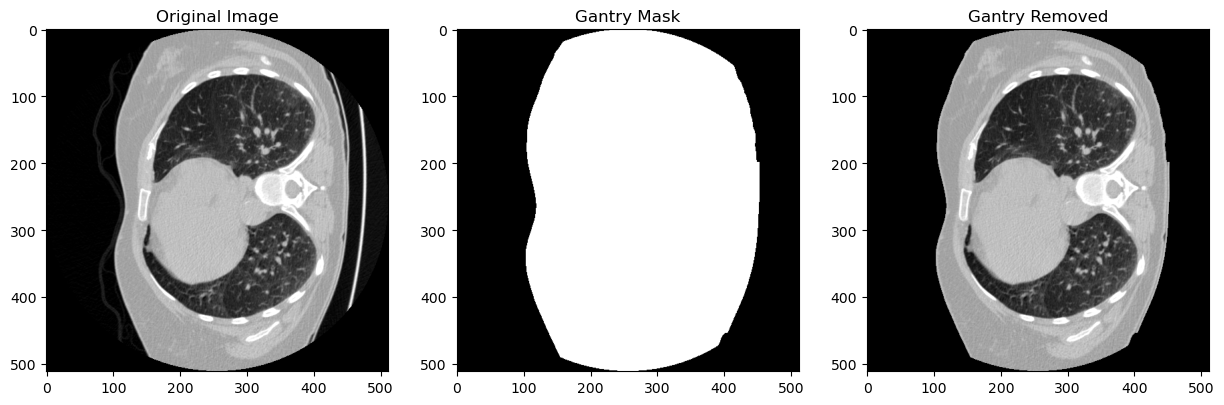

In [9]:
gantry_inhale = remove_gantry(hu_inhale, visualize=True)
gantry_exhale = remove_gantry(hu_exhale, visualize=True)

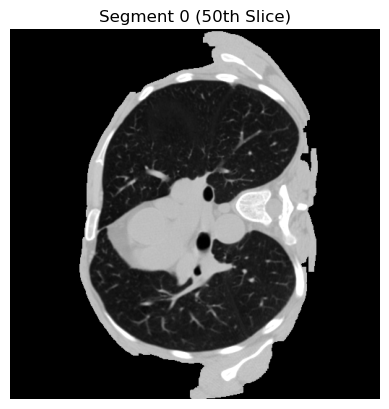

In [10]:
# Plot the 50th slice of segment 0
plt.imshow(gantry_inhale[:, :, 50], cmap='gray')
plt.title("Segment 0 (50th Slice)")
plt.axis('off')
plt.show()